In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV #this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [3]:
df = pd.read_csv("default of credit card clients.txt",sep='\t',header=1)
df.drop('ID',axis=1,inplace=True)
df.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True)
df_no_missing = df.loc[(df['MARRIAGE']!=0) & (df['EDUCATION']!=0)]
df_no_missing.head()
df_no_default = df_no_missing[df_no_missing['DEFAULT']==0]
df_default = df_no_missing[df_no_missing['DEFAULT']==1]
df_no_default_downsampled = resample(df_no_default,replace=False,n_samples=1000,random_state=42)
df_default_downsampled = resample(df_default,replace=False,n_samples=1000,random_state=42)
df_downsampled = pd.concat([df_no_default_downsampled,df_default_downsampled])
X = df_downsampled.drop(['DEFAULT','SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'],axis=1).copy()
y = df_downsampled['DEFAULT'].copy()
#X_encoded = pd.get_dummies(X,columns=['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']).astype(int)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
print("pre-proccessing");

pre-proccessing


Number of columns: 14


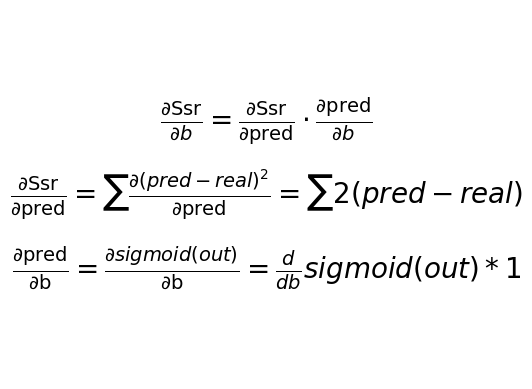

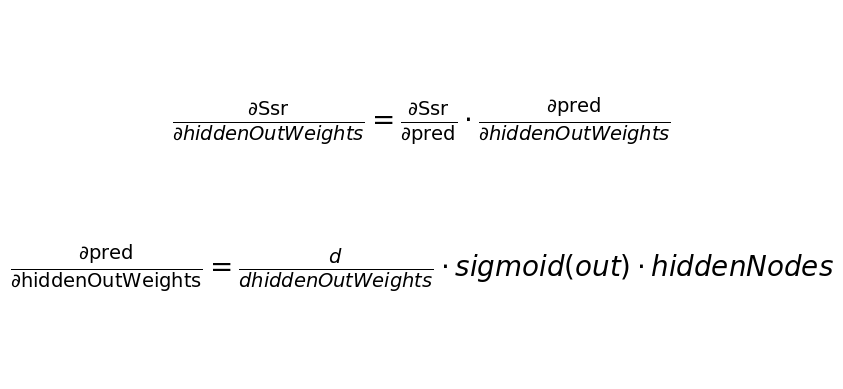

In [166]:
print(f"Number of columns: {X_train_scaled.shape[1]}")
input_nodes_num = X_train_scaled.shape[1]
hidden_nodes_num = 8
output_nodes_num = 1
np.random.seed(42)

#hidden-input layer wieghts and biases
input_hidden_weights = np.random.randn(input_nodes_num,hidden_nodes_num)
input_hidden_baises = np.random.randn(hidden_nodes_num)

#hidden-output layer wieghts and biases
hidden_out_weights = np.random.randn(hidden_nodes_num,output_nodes_num)
hidden_out_baises=0
equation1 = r'$\frac{\partial \text{Ssr}}{\partial b} = \frac{\partial \text{Ssr}}{\partial \text{pred}} \cdot \frac{\partial \text{pred}}{\partial b}$'
equation2 = r'$\frac{\partial \text{Ssr}}{\partial \text{pred}} = \sum\frac{\partial (pred - real)^{2}}{\partial \text{pred}} = \sum2(pred - real)$'
equation3 = r'$\frac{\partial \text{pred}}{\partial \text{b}} = \frac{\partial sigmoid(out)}{\partial \text{b}} = \frac{d}{db}sigmoid(out)*1$'    
plotEquations(equation1,equation2,equation3)
equation1 = r'$\frac{\partial \text{Ssr}}{\partial hiddenOutWeights} = \frac{\partial \text{Ssr}}{\partial \text{pred}} \cdot \frac{\partial \text{pred}}{\partial hiddenOutWeights}$' 
equation2 = ''
equation3 = r'$\frac{\partial \text{pred}}{\partial \text{hiddenOutWeights}} =  \frac{d}{dhiddenOutWeights} \cdot sigmoid(out)\cdot hiddenNodes$'    
plotEquations(equation1,equation2,equation3)


In [201]:
#sum of squared residuals
learning_rete = 0.01;
hidden_out_baises = -50
hidden_layer_outputs = []
predicated_values = []

for epoch in range(1):
    ssr = 0;
    predicated_values = []
    for i in range(0,len(X_train_scaled)):
        input_nodes = X_train_scaled[i]
        pred,hidden_nodes = forward(input_nodes,input_hidden_weights,hidden_out_weights,input_hidden_baises,hidden_out_baises)
        real = y_train.iloc[i]
        predicated_values.append(pred)
        hidden_layer_outputs.append(hidden_nodes)
        
    predicated_values = np.array(predicated_values)
    hidden_layer_outputs = np.array(hidden_layer_outputs)
    observed_values =  y_train.to_numpy()
    
    ssr = np.sum((predicated_values-observed_values)**2)

    dSSR_dpred = 2 * (predicated_values - observed_values)*predicated_values*(1-predicated_values)
    
    d_output_weights = np.dot(dSSR_dpred, hidden_layer_outputs)
    
    d_output_biases = np.sum(dSSR_dpred)
    
    hidden_out_baises -= learning_rete*db;
    #hidden_out_weights -= learning_rete*dw2;
    print(ssr)
    print(d_output_weights)


1135475.523889393
[[-1.18214521e-22 -6.33094626e-22 -1.20268326e-22 ... -2.52897237e-22
  -4.75795676e-22 -2.71345278e-22]
 [-6.08209507e-21 -3.25724932e-20 -6.18776259e-21 ... -1.30114729e-20
  -2.44795183e-20 -1.39606180e-20]
 [-2.20145988e-19 -1.17898580e-18 -2.23970703e-19 ... -4.70960009e-19
  -8.86054505e-19 -5.05315029e-19]
 ...
 [-3.64118247e-21 -1.95002528e-20 -3.70444270e-21 ... -7.78960973e-21
  -1.46552120e-20 -8.35783675e-21]
 [-1.27641143e-20 -6.83578641e-20 -1.29858722e-20 ... -2.73063682e-20
  -5.13736413e-20 -2.92982801e-20]
 [-2.24401700e-18 -1.20177715e-17 -2.28300352e-18 ... -4.80064286e-18
  -9.03183105e-18 -5.15083434e-18]]


In [167]:
def forward(input_nodes1,input_hidden_weights1,hidden_out_weights1,input_hidden_baises1,hidden_out_baises1):
    #initialize hidden nodes
    hidden_nodes1 = np.dot(input_nodes1,input_hidden_weights1)
    hidden_nodes1 = np.add(hidden_nodes1,input_hidden_baises1)
    hidden_nodes1 = relu(hidden_nodes1)
    #initialize out node
    output_node1 = np.dot(hidden_nodes1,hidden_out_weights1)
    output_node1 = np.add(output_node1,hidden_out_baises1)
    predictions1 = sigmoid(output_node1)
    return predictions1,hidden_nodes1
    
def plotEquations(q1,q2,q3):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()

    ax.axis('off')
    
    ax.text(0.5, 0.7, q1, fontsize=20, ha='center', va='center')
    
    ax.text(0.5, 0.5, q2, fontsize=20, ha='center', va='center')
    
    ax.text(0.5, 0.3, q3, fontsize=20, ha='center', va='center')
    
    plt.savefig('equations.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def relu(x):
    return np.maximum(0, x) 
def sigmoid_derivative(x):
    sigmoid_x = sigmoid(x)
    return sigmoid_x * (1 - sigmoid_x)